In [1]:
!gdown --id 1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj

Downloading...
From: https://drive.google.com/uc?id=1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj
To: /content/PageSegData.zip
40.4MB [00:00, 111MB/s] 


In [2]:
!unzip PageSegData

Archive:  PageSegData.zip
replace PageSegData/PageImg/1.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: PageSegData/PageImg/1.JPG  
  inflating: PageSegData/PageImg/10.JPG  
  inflating: PageSegData/PageImg/100.JPG  
  inflating: PageSegData/PageImg/101.JPG  
  inflating: PageSegData/PageImg/102.JPG  
  inflating: PageSegData/PageImg/103.JPG  
  inflating: PageSegData/PageImg/104.JPG  
  inflating: PageSegData/PageImg/105.JPG  
  inflating: PageSegData/PageImg/106.JPG  
  inflating: PageSegData/PageImg/107.JPG  
  inflating: PageSegData/PageImg/108.JPG  
  inflating: PageSegData/PageImg/109.JPG  
  inflating: PageSegData/PageImg/11.JPG  
  inflating: PageSegData/PageImg/110.JPG  
  inflating: PageSegData/PageImg/111.JPG  
  inflating: PageSegData/PageImg/112.JPG  
  inflating: PageSegData/PageImg/113.JPG  
  inflating: PageSegData/PageImg/114.JPG  
  inflating: PageSegData/PageImg/115.JPG  
  inflating: PageSegData/PageImg/116.JPG  
  inflating: PageSegData/PageImg/117.JPG  


In [3]:
#Importing required libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random

image_list=os.listdir('/content/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]

def visualize(img,seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()
    
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]

    
    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels
def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)


Using TensorFlow backend.


In [4]:
image_list[0]

'109'

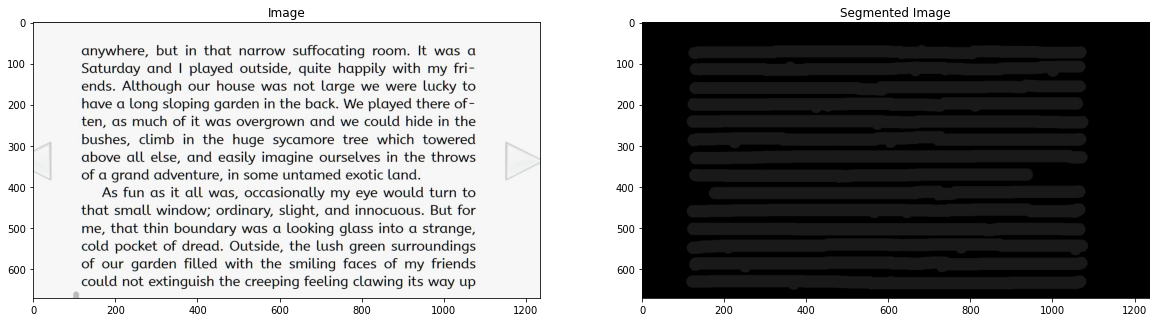

In [5]:
img=cv2.imread('/content/PageSegData/PageImg/'+image_list[0]+'.JPG',1)
seg=cv2.imread('/content/PageSegData/PageSeg/'+image_list[0]+'_mask.png',1)

visualize(img,seg)

In [6]:


def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

#model = FCN(n_classes=2,  
            #  input_height=320, 
            #  input_width=320)
model=unet()
model.summary()
    
    


        

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [7]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]



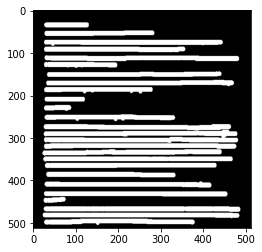

In [8]:
img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [10]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('weights{epoch:08d}.h5', 
                                     save_weights_only=True, period=1)
model.fit_generator(batch_generator(file_train,2,2),epochs=3,steps_per_epoch=1000,validation_data=batch_generator(file_test,2,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)

Epoch 1/3
1000/1000 [==============================] - 813s 813ms/step - loss: 0.1776 - accuracy: 0.9264 - val_loss: 0.2502 - val_accuracy: 0.9282
Epoch 2/3
1000/1000 [==============================] - 810s 810ms/step - loss: 0.1447 - accuracy: 0.9367 - val_loss: 0.1501 - val_accuracy: 0.9380
Epoch 3/3
1000/1000 [==============================] - 809s 809ms/step - loss: 0.1337 - accuracy: 0.9413 - val_loss: 0.1677 - val_accuracy: 0.9417


In [16]:
import seaborn as sns
img=cv2.imread(f'/content/test_img.JPG',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)




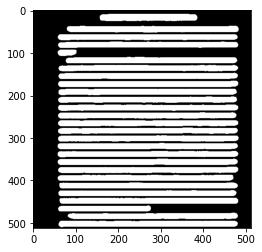

In [17]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [18]:
plt.imsave('test_img_mask.JPG',pred)

In [14]:
coordinates=[]

In [19]:
import cv2
img = cv2.imread('/content/test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/test_img.JPG')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imwrite("output.png",ori_img)

True